In [16]:
import fitdecode
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime, timezone, timedelta
from activity import load_fitfile, ActivityPoint, Activity, convert_str_timestamp
from performance import model_bannister, model_tsb, calc_daily_trimp
import os
import json
import glob
import tqdm
import pandas as pd
import numpy as np


In [2]:
start = datetime(2023,12,26,tzinfo=timezone.utc)
end = datetime(2024,1,16,tzinfo=timezone.utc)

In [3]:
act_fns = glob.glob('../runquant_data/data/activities/*jsonl')
activities = []
print(len(act_fns))
for act_fn in tqdm.tqdm(act_fns):
    if int(os.path.basename(act_fn).split('_')[0]) >= int(start.timestamp()):
        with open(act_fn,'r') as f:
            stream = list(f)
        activity = Activity([ActivityPoint(**json.loads(row)) for row in stream])
        activities.append(activity)
print(f'{len(activities)} activites in the training block out of {(end-start).days} days')


1626


  0%|          | 0/1626 [00:00<?, ?it/s]

100%|██████████| 1626/1626 [00:03<00:00, 517.87it/s]

14 activites in the training block out of 21 days


In [4]:
from athlete import Athlete
athlete = Athlete(0)

In [5]:
trimps = calc_daily_trimp(activities, athlete)

In [6]:
# total TRIMP
sum(trimps.values())

2275.408633855158

In [7]:
df = pd.DataFrame.from_dict(trimps,orient='index')
df.reset_index(inplace=True)
df.columns=['date','trimp']
df['date'] = pd.to_datetime(df['date'])
df = df.sort_values(by='date',ascending=True)
df.reset_index(drop=True,inplace=True)

<Axes: xlabel='date'>

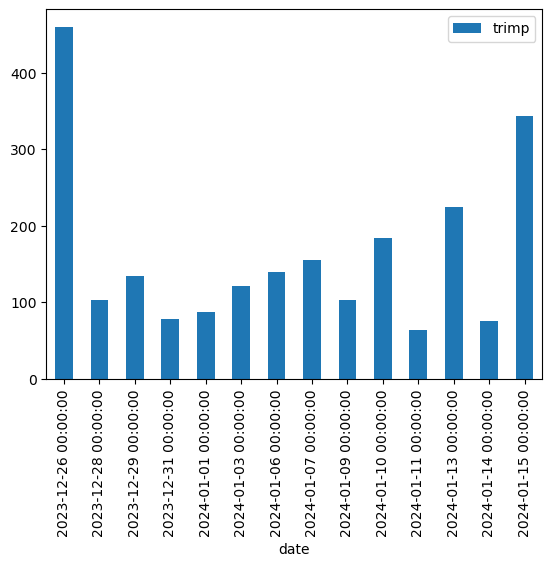

In [8]:
df.plot(x='date',y='trimp',kind='bar')

In [9]:
## heart rate


In [10]:
zones = {1:(0,120),
         2:(121,149),
         3:(150,164),
         4:(165,179),
         5:(180,220)
         }

In [14]:
# want to get heartrate(hr) from every second of activity in the block.

# get hr datapoints from every second of activity in the block
# because we don't get a watch ping every second, do the stupidest thing
# and just impute missing hr values based on the next hr reading
all_hr = []
from performance import align_hr_and_ts
for activity in activities:
    hr,ts,hr_ts = align_hr_and_ts(activity)
    all_hr.extend(hr_ts)

# now bucket to hr zones


In [38]:
b = [x[1] for x in zones.values()]
b.insert(0,0)
counts,zone_edges = np.histogram(all_hr, bins=b)

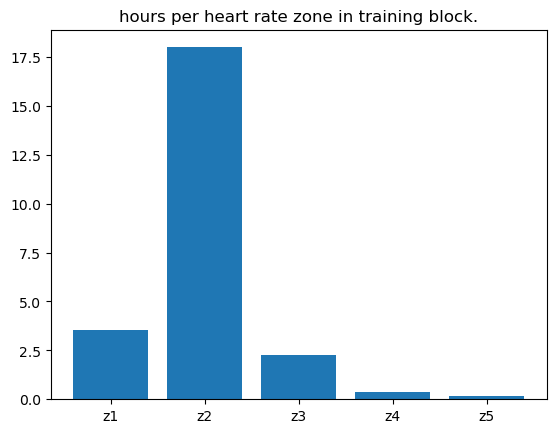

In [55]:
fig,ax = plt.subplots()
ax.set_title('hours per heart rate zone in training block.')
ax.bar(range(len(counts)),height=[round(c/3600,2) for c in counts])
ax.set_xticks(range(len(counts)))
ax.set_xticklabels([f'z{i+1}' for i in range(5)]);